In [164]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pprint
import csv
import datetime
import math
import os

In [165]:
def extract_time(t1,t2,t3=None,t4=None):
    
    if isinstance(t1,float) and isinstance(t2,float) and isinstance(t3,float) and isinstance(t4,float):
        return (t2-t1)+(t4-t3)

    if isinstance(t1,float) and isinstance(t2,float) and t3 is None and t4 is None:
        return t2-t1
    
    
    if isinstance(t1,basestring):
        try:
            t1 = datetime.datetime.strptime(t1, "%Y-%m-%d %H:%M:%S.%f")
        except:
            t1 = datetime.datetime.strptime(t1, "%Y-%m-%d %H:%M:%S")
    if isinstance(t2,basestring):
        try:
            t2  = datetime.datetime.strptime(t2, "%Y-%m-%d %H:%M:%S.%f")
        except:
            t2  = datetime.datetime.strptime(t2, "%Y-%m-%d %H:%M:%S")

    if t3 is not None and isinstance(t3,basestring):
        
        try:
            t3   = datetime.datetime.strptime(t3, "%Y-%m-%d %H:%M:%S.%f")
        except:
            t3   = datetime.datetime.strptime(t3, "%Y-%m-%d %H:%M:%S")
    if t4 is not None and isinstance(t4,basestring):
        try:
            t4  = datetime.datetime.strptime(t4, "%Y-%m-%d %H:%M:%S.%f")
        except:
            t4  = datetime.datetime.strptime(t4, "%Y-%m-%d %H:%M:%S")
            
        return ((t2-t1)+(t4-t3)).total_seconds()
    
    else:
        if t3 is not None and t4 is not None:
            return ((t2-t1)+(t4-t3)).total_seconds()
        else:        
            return (t2-t1).total_seconds()

In [166]:
def extract_core_overhead(df):
    alloc_start,alloc_stop,dealloc_start,dealloc_stop = df['timestamp']
    core_ov = extract_time(alloc_start,alloc_stop,dealloc_start,dealloc_stop)
    
    return core_ov

In [167]:
# df_pat = pd.read_csv('enmd_pat_overhead_1_42.csv')
# overhead = extract_pat_overhead(df_pat)
# df_pat

# overhead

In [168]:
def extract_pat_overhead(df):
    step_1_df = df[0:4]
    step_2_df = df[4:8]
    
    
    #print sim_df['timestamp']
    
    start1,wait1,res1,stop1 = step_1_df['timestamp']
    step_1_ov = extract_time(start1,wait1,res1,stop1)
    #part2 = extract_time(start2,wait2,res2,stop2)
    #post = extract_time(post_start,post_stop)    
    #step_1_ov = part1 + part2 + post

    start2,wait2,res2,stop2 = step_2_df['timestamp']
    step_2_ov = extract_time(start2,wait2,res2,stop2)
    #part2 = extract_time(start2,wait2,res2,stop2)
    #post = extract_time(post_start,post_stop)    
    #ana_ov = part1 + part2 + post
    
    return step_1_ov + step_2_ov

In [169]:
def extract_timing_info(df,cores,inst):
    
    step_1_data, step_2_data = extract_data_time(df,cores,inst)
    step_1_exec, step_2_exec = extract_exec_time(df,cores,inst)
    
    return [step_1_data,step_2_data],[step_1_exec, step_2_exec]

In [170]:
# df_profile = pd.read_csv('pipeline_data/profile_32_1.csv')
#df_profile[[u' step',u' StagingInput',u' Allocating',u' PendingAgentOutputStaging',u' Done']]

In [171]:
def extract_rp_overhead(df,data,exec_list):
    
    #pre_loop_df = df[0:1]
    step_1_df = df[0:4]
    step_2_df = df[4:8]
    
    start1,wait1,res1,stop1 = step_1_df['timestamp']
    
    step_1_wait = extract_time(wait1,res1)
    step_1_rp_ov = step_1_wait - data[0] - exec_list[0]
    
    
    start1,wait1,res1,stop1 = step_2_df['timestamp']
    #print start1,wait1,res1,stop1
    step_2_wait = extract_time(wait1,res1)
    #print step_2_wait, data[1], exec_list[1]
    step_2_rp_ov = step_2_wait - data[1] - exec_list[1]
    
    
    
    rp_ov = step_1_rp_ov + step_2_rp_ov
    
    
    #print preloop_rp_ov, sim_rp_ov, ana_rp_ov
    
    return rp_ov

In [172]:
def extract_data_time(df,cores,inst):
    print df
    req_df = df[[u'step',u'StagingInput',u'Allocating',u'AgentStagingOutputPending',u'Done']]
    
    
    rows = req_df.shape[0]
    half = rows/2
    #preloop_df = req_df[:1]
    step_1_df = req_df[0:half]
    step_2_df = req_df[half:]
    
    #preloop_data = None
    step_1_data = None
    step_2_data = None
    
    #Step_1 extraction
    per_unit_data_time  = list()
    for row in step_1_df.iterrows():
        step,t1,t2,t3,t4 = row[1:][0]
        #print t1,t2,t3,t4
        per_unit_data_time.append(extract_time(t1,t2,t3,t4))
   
    
    if cores == inst:
        #kern_1 = per_unit_data_time[:inst]
        #kern_2 = per_unit_data_time[inst:]
        
        step_1_data = np.average(per_unit_data_time)
    elif inst > cores:
        pass
    
    
    #Step_2 extraction
    per_unit_data_time  = list()
    for row in step_2_df.iterrows():
        step,t1,t2,t3,t4 = row[1:][0]
        #        print "Cores = Inst"
        #print extract_time(t1,t2,t3,t4)
        #print "{0},{1},{2},{3}".format(t1,t2,t3,t4)
        per_unit_data_time.append(extract_time(t1,t2,t3,t4))
    

    #print step_print df.columns2_df
    #print per_unit_data_time
    if cores == inst:
        #kern_1 = per_unit_data_time[:inst]
        #kern_2 = per_unit_data_time[inst:]
        step_2_data = np.average(per_unit_data_time)
    elif inst > cores:
        pass
    
    
    
    #print preloop_data, sim_data, ana_data
    #return preloop_data, sim_data, ana_data
    #print step_1_data, step_2_data
    return step_1_data, step_2_data

In [173]:
def extract_exec_time(df,cores,inst):
    req_df = df[[u'step',u'Executing',u'AgentStagingOutputPending']]
    
    rows = req_df.shape[0]
    half = rows/2
    step_1_df = req_df[0:half]
    step_2_df = req_df[half:]
    
    #preloop_exec = None   
    step_1_exec = None
    step_2_exec = None
    
    
    # Preloop extraction
    #step,t1,t2 =  preloop_df.loc[0,:]
    #preloop_exec = extract_time(t1,t2)

    
    #Simulation extraction
    #STUPID ME SET CORES PER CU = 2!!
    per_unit_exec_time  = list()
    for row in step_1_df.iterrows():
        step,t1,t2 = row[1:][0]
        #print t1,t2,t3,t4
        #print row
        per_unit_exec_time.append(extract_time(t1,t2))
        
    if cores == inst:
        step_1_exec = np.average(per_unit_exec_time)
    elif inst > cores:
        pass
    
  
    
    #Analysis extraction
    per_unit_exec_time  = list()
    for row in step_2_df.iterrows():
        step,t1,t2 = row[1:][0]
        #print t1,t2,t3,t4
        #print row
        per_unit_exec_time.append(extract_time(t1,t2))
        
    if cores == inst:
        step_2_exec = np.average(per_unit_exec_time)
    elif inst > cores:
        pass
    
    
    
    #print preloop_exec, sim_exec, ana_exec
    #return preloop_exec, sim_exec, ana_exec
    return step_1_exec, step_2_exec

In [174]:
def separate(comp_df,err_df):
    ov_df = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead'])
    ov_df_err = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead'])
    ov_df['EnMD Core overhead'] = comp_df['EnMD Core overhead']
    ov_df['EnMD Pat overhead'] = comp_df['EnMD Pat overhead']
    ov_df['RP overhead'] = comp_df['RP overhead']
    
    ov_df_err['EnMD Core overhead'] = err_df['EnMD Core overhead']
    ov_df_err['EnMD Pat overhead'] = err_df['EnMD Pat overhead']
    ov_df_err['RP overhead'] = err_df['RP overhead']
    
    
    
    app_df = pd.DataFrame(columns=['Step 1 execution time',
                                'Step 2 execution time'])
    app_df_err = pd.DataFrame(columns=['Step 1 execution time',
                                'Step 2 execution time'])
    app_df['Step 1 execution time'] = comp_df['Step 1 execution time']
    app_df['Step 2 execution time'] = comp_df['Step 2 execution time']
    
    app_df_err['Step 2 execution time'] = err_df['Step 2 execution time']
    app_df_err['Step 2 execution time'] = err_df['Step 2 execution time']
    
    
    
    data_df = pd.DataFrame(columns=['data movement'])
    data_df_err = pd.DataFrame(columns=['data movement'])
    data_df['data movement'] = comp_df['data movement']
    data_df_err['data movement'] = err_df['data movement']
    
    split_plot([ov_df,ov_df_err],[app_df,app_df_err],[data_df,data_df_err])

In [175]:
def split_plot(ov,app,data):
    fig, axes = plt.subplots(nrows=3, ncols=1)
    ax1 = ov[0].plot(ax=axes[0],kind='bar',stacked=False,
               title='Overhead: Makefile and CharCount Using Pipeline on Stampede',
               colors=['black','green','red'],ylim=(0,50),fontsize=12,rot=0,yerr=ov[1])
    ax2 = app[0].plot(ax=axes[1],kind='bar',stacked=False,
               title='Application: Makefile and CharCount Using Pipeline on Stampede',
               colors=['purple','blue','yellow'],ylim=(0,5),fontsize=12,rot=0,yerr=app[1])
    ax3 = data[0].plot(ax=axes[2],kind='bar',stacked=False,
               title='Data Movement: Makefile and CharCount Using Pipeline on Stampede',
               colors=['brown'],ylim=(0,50),fontsize=12,rot=0,yerr=data[1])
    
    ax2.set_xlabel('Cores/No. of simulations',fontsize=12)
    ax2.set_ylabel('Time (seconds)',fontsize=12)
    ax2.legend(fontsize=12,loc='upper left')
    ax2.set_title(ax2.get_title(),fontsize=12)
    ax1.set_xlabel('Cores/No. of simulations',fontsize=12)
    ax1.set_ylabel('Time (seconds)',fontsize=12)
    ax1.legend(fontsize=12,loc='upper left')
    ax1.set_title(ax1.get_title(),fontsize=12)
    ax3.set_xlabel('Cores/No. of simulations',fontsize=12)
    ax3.set_ylabel('Time (seconds)',fontsize=12)
    ax3.legend(fontsize=12,loc='upper left')
    ax3.set_title(ax3.get_title(),fontsize=12)
    
    fig.set_size_inches(12,12)
    fig.subplots_adjust(hspace=.4)
    
    ax1.grid()
    ax2.grid()
    ax3.grid()
    plt.savefig('/home/shenoy/Documents/Nikhil/research/RADICAL-research/testing/summary/iteration_3/pipeline_strong_scaling.png')

           uid    step    Scheduling  StagingInput  AgentStagingInputPending  \
0  unit.000024  step_1  1.456692e+09  1.456692e+09              1.456692e+09   
1  unit.000025  step_2  1.456692e+09  1.456692e+09              1.456692e+09   

   AgentStagingInput  AllocatingPending    Allocating  ExecutingPending  \
0       1.456692e+09       1.456692e+09  1.456692e+09      1.456692e+09   
1       1.456692e+09       1.456692e+09  1.456692e+09      1.456692e+09   

      Executing  AgentStagingOutputPending  AgentStagingOutput  \
0  1.456692e+09               1.456692e+09        1.456692e+09   
1  1.456692e+09               1.456692e+09        1.456692e+09   

   PendingOutputStaging  StagingOutput          Done  
0          1.456692e+09   1.456692e+09  1.456692e+09  
1          1.456692e+09   1.456692e+09  1.456692e+09  
           uid    step    Scheduling  StagingInput  AgentStagingInputPending  \
0  unit.000010  step_1  1.456690e+09  1.456690e+09              1.456690e+09   
1  unit.0

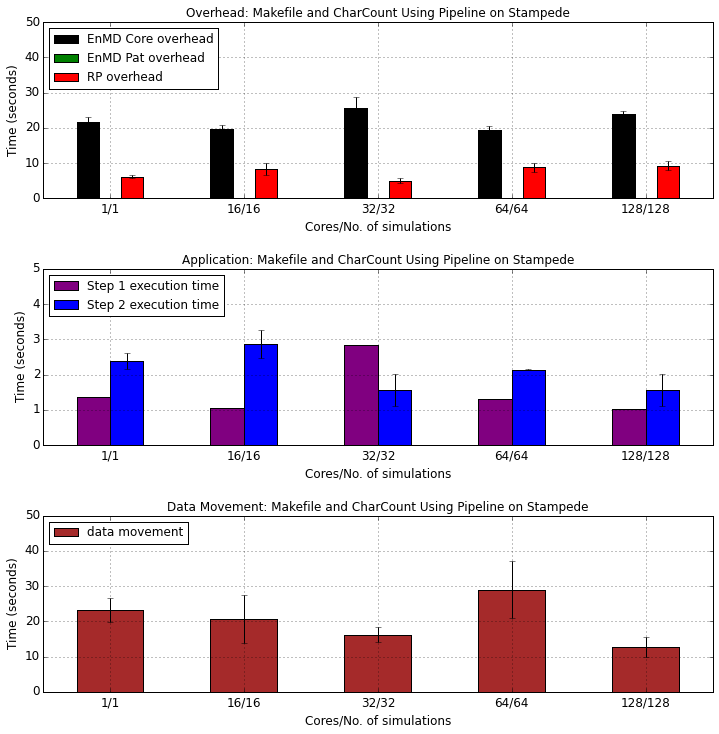

In [176]:
#MAIN

comp_df = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead',
                                'Step 1 execution time',
                                'Step 2 execution time',
                                'data movement'])

err_df = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead',
                                'Step 1 execution time',
                               'Step 2 execution time',
                                'data movement'])

path = "/home/shenoy/Documents/Nikhil/research/enmd-pattern-testing/old/nikhil_postmortem_analyses/strong_scaling/pipeline_data/"
cores = [1,16,32,64,128]
trials = 4
for c in cores:
    
    core_ov_list = list()
    pat_ov_list = list()
    rp_ov_list = list()
    data_list = list()
    #preloop_exec_list = list()
    step_1_exec_list = list()
    step_2_exec_list = list()
    
    for t in range(0,trials):
        
        #f_core = open('experiment_iter{0}_p{1}_i{1}/enmd_core_overhead.csv'.format(t,c))
        df_core = pd.read_csv(path + 'enmd_core_overhead_{0}_{1}.csv'.format(c,t),header=0,sep=',',skipinitialspace=True)
        df_pat = pd.read_csv(path + 'enmd_pat_overhead_{0}_{1}.csv'.format(c,t),header=0,sep=',',skipinitialspace=True)
        df_profile = pd.read_csv(path + 'profile_{0}_{1}.csv'.format(c,t),header=0,sep=',',skipinitialspace=True)
        core_ov = extract_core_overhead(df_core)
        pat_ov = extract_pat_overhead(df_pat)
        data, exec_list = extract_timing_info(df_profile,cores=c,inst=c)
        rp_ov = extract_rp_overhead(df_pat,data,exec_list)
        
        core_ov_list.append(core_ov)
        pat_ov_list.append(pat_ov)
        rp_ov_list.append(rp_ov)
        #preloop_exec_list.append(exec_list[0])
        step_1_exec_list.append(exec_list[0])
        step_2_exec_list.append(exec_list[1])
        data_list.append(sum(data))
        #print rp_ov_list
        
    #print 'Core ov: ',core_ov_list
    #print 'Pat ov: ',pat_ov_list
    #print 'Data mov: ',data_list
    #print 'Preloop exec: ',preloop_exec_list
    #print 'Sim exec: ',sim_exec_list
    #print 'Ana exec: ',ana_exec_list
    
    comp_df.loc['{0}/{1}'.format(c,c)] = [np.average(core_ov_list),
                                          np.average(pat_ov_list),
                                          np.average(rp_ov_list),
                                          #np.average(preloop_exec_list),
                                          np.average(step_1_exec_list),
                                          np.average(step_2_exec_list),
                                          np.average(data_list)]
    
    err_df.loc['{0}/{1}'.format(c,c)] = [
                                          np.std(core_ov_list)/math.sqrt(trials),
                                          np.std(pat_ov_list)/math.sqrt(trials),
                                          np.std(rp_ov_list)/math.sqrt(trials),
                                          #np.std(preloop_exec_list)/math.sqrt(trials),
                                          np.std(step_1_exec_list)/math.sqrt(trials),
                                          np.std(step_2_exec_list)/math.sqrt(trials),
                                          np.std(data_list)/math.sqrt(trials)
                                         ]


separate(comp_df,err_df)